데이터 분석의 방향을 설정하기 위해 데이터의 생김새 확인이 필요합니다.  
EDA 방법으로는 3가지 방법으로 나눌 수 있습니다.  

* input이 될 X에 대한 분석  
* target이 될 y에 대한 분석  
* X, y 관계를 확인할 수 있는 분석  
  
  
위 같은 케이스를 Image classification으로 가져온다면  

* input이 될 X에 대한 분석  
X는 Image가 됩니다. X에 대한 특성(feature)은 어떤 것이 있을까요??  
이미지 사이즈  
분석 대상이 되는 객체의 위치  
RGB 채널별 통계 값  
  
* target이 될 y에 대한 분석  
y는 저희가 맞추고자 하는 값이며 y값에 대한 특성은 어떤 것이 있을까요??  
y값에 독립적 분포 확인  
ex) y_1의 분포는?  
y값 들간의 관계 분포 확인  
ex) y_1, y_2 정보를 섞은 분포는?  
  
* X, y 관계를 확인할 수 있는 분석  
X특성과 y의 특성 간의 분포 차이는 어떻게 있을까요??  
이미지 사이즈와 y 특성의 관계  
RGB 통계값과 y 특성의 관계  
객체의 위치와 y 특성의 관계  
데이터의 노이즈 확인  
ex) y값이 잘못 부여된것이 있을까??  

## import modules

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from glob import glob
from PIL import Image
from tqdm import tqdm
import cv2

In [37]:
## 재미있는 아이디어
class cfg:
    my_path = '/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/dataset/train'
    img_dir = f'{my_path}/images'
    df_path = f'{my_path}/train.csv'

In [38]:
cfg.img_dir

'/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/dataset/train/images'

In [39]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3', 'mask4','mask5','normal']
class2num = {k:v for k,v in enumerate(num2class)}

In [92]:
df = pd.read_csv(cfg.df_path)
df.head()

## df.path.values --> 파일의 폴더명을 확인할 수 있음
# ['000001_female_Asian_45' '000002_female_Asian_52' '000004_male_Asian_54'
#  ... '006956_male_Asian_19' '006957_male_Asian_20' '006959_male_Asian_19']

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [93]:
def get_ext(img_dir, img_id):
    filename = os.listdir(os.path.join(img_dir, img_id))[0] # mask1.jpg
    ## os.path.splitext(filename) --> ('mask1', '.jpg')
    ext = os.path.splitext(filename)[-1].lower()
    return ext

get_ext(cfg.img_dir, '000001_female_Asian_45')

'.jpg'

## show image statistics  
* glob()의 활용.  
* list element를 가진 dict의 활용.  

In [63]:
def get_img_stats(img_dir, img_ids):
    """summary: 폴더 경로와 폴더명 리스트를 받아와 이미지의 h, w, m, s가 담긴 dict를 리턴하는 함수.
       key idea: dict element로 리스트를 선언해서 계속 append.
    Args:
        img_dir (str): 이미지 폴더의 경로
        img_ids (list): 폴더명이 담긴 리스트
    
    Returns:
        img_info(dict): 이미지들의 h,w,m,s가 담긴 dict
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id,'*')) : # img_dir/img_id/*에 해당하는 모든파일의 path를 따옴.
            img = np.array(Image.open(path)) # 각 파일의 이미지를 읽어오고 이를 np로 변환.
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

img_info = get_img_stats(cfg.img_dir, os.listdir(cfg.img_dir)[:100])

100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


In [89]:
print(f'num of people : {len(os.listdir(cfg.img_dir))}')
print(f'num of image : {len(os.listdir(cfg.img_dir))*7}')
print()
print(f'max image size : {np.max(img_info["heights"])} X {np.max(img_info["widths"])}' )
print(f'min image size : {np.min(img_info["heights"])} X {np.min(img_info["widths"])}' )
print(f'average image size : {np.mean(img_info["heights"])} X {np.mean(img_info["widths"])}')
print()
print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

num of people : 2700
num of image : 18900

max image size : 512 X 384
min image size : 512 X 384
average image size : 512.0 X 384.0

RGB Mean: [0.54940942 0.51256015 0.4887544 ]
RGB Standard Deviation: [0.2380686  0.24447301 0.24588797]


## show some samples  
* 이미지 resize가 아니라 crop이 필요함.  

In [90]:
os.getcwd()

'/opt/ml/repo/level1_imageclassification_cv-level1-cv-06/T4064/dataset/train'

In [118]:
imgs = []
img_id = df.iloc[600].path
ext = get_ext(cfg.img_dir, img_id)

for img_path in glob(os.path.join(cfg.img_dir,img_id+'/*')):
    imgs.append(np.array(Image.open(img_path)))
imgs = np.array(imgs)
len(imgs)

7

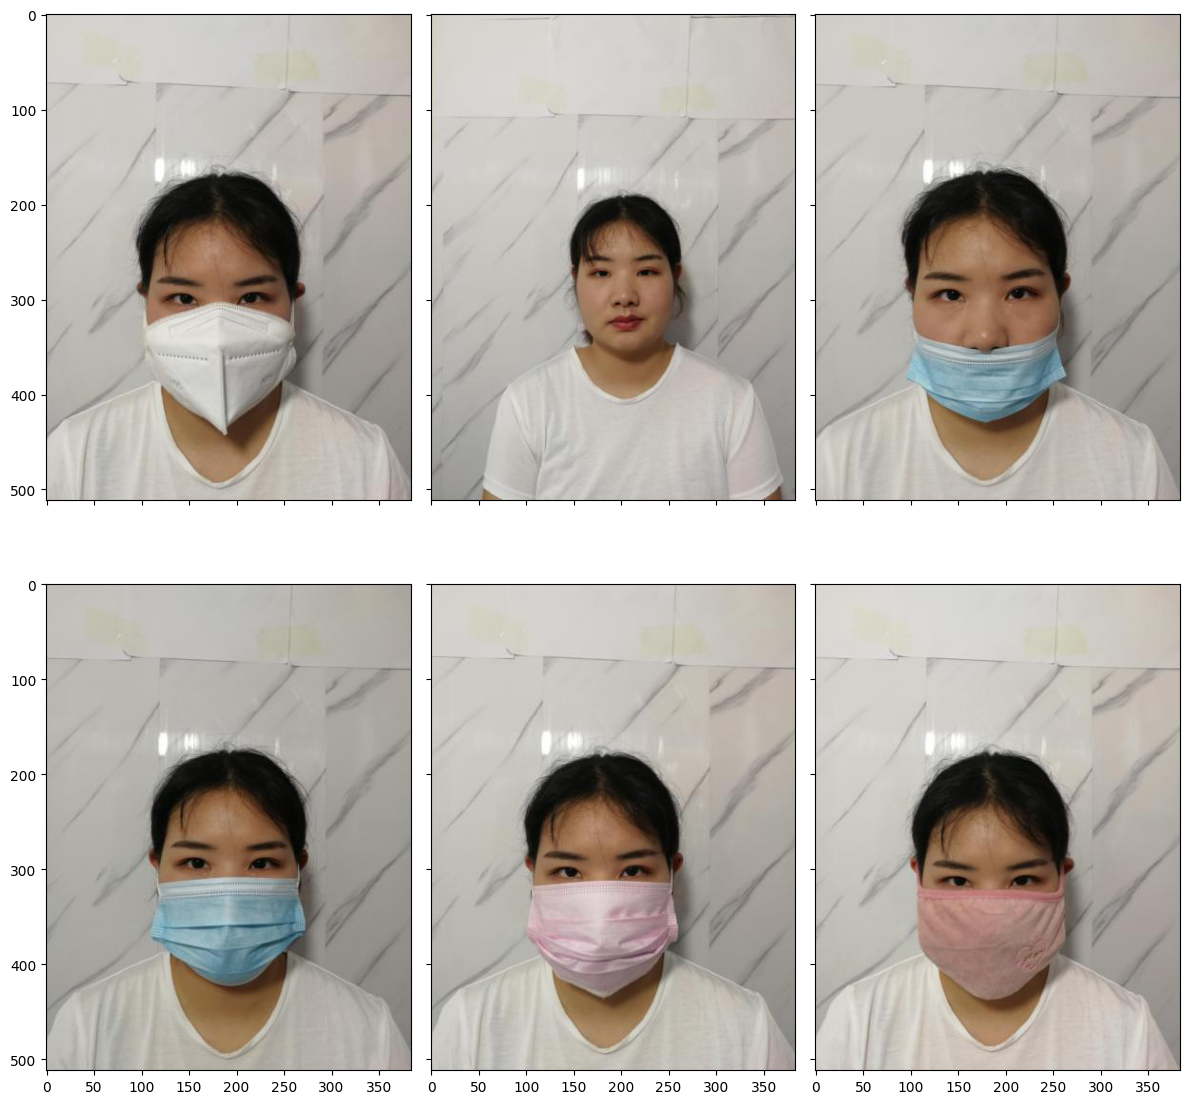

In [120]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 12))
axes[0][0].imshow(imgs[0])
axes[0][1].imshow(imgs[1])
axes[0][2].imshow(imgs[2])
axes[1][0].imshow(imgs[3])
axes[1][1].imshow(imgs[4])
axes[1][2].imshow(imgs[5])
fig.tight_layout()
plt.show()

## show distribution of labels  
* 여성 : 남성 = 61.41% : 38.59% 으로 여성에 Bias 되어 있음.  
* age feature가 상당히 imbalance함.  
* 남성과 여성의 데이터 개수 차이는 20대와, 45세 이상에서 차이가 많이 발생함.  

In [138]:
counts = df['gender'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
print(counts_pct) ## 

['61.41%', '38.59%']


<Figure size 500x500 with 0 Axes>

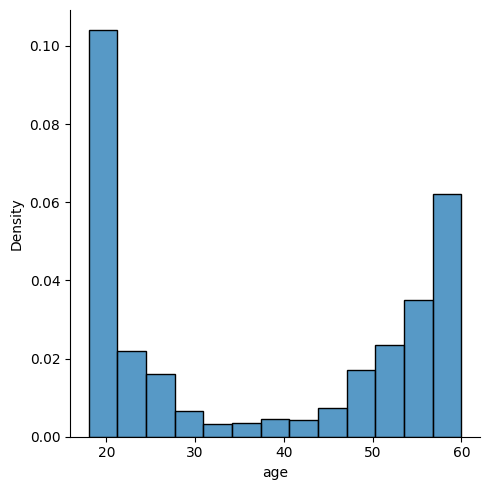

In [157]:
plt.figure(figsize=(5,5))
sns.displot(df, x="age", stat="density")
plt.show()

<Figure size 500x500 with 0 Axes>

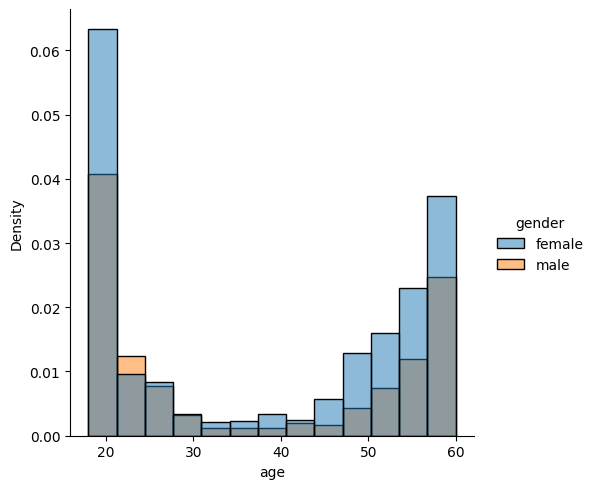

In [158]:
plt.figure(figsize=(5,5))
sns.displot(df, x="age", hue="gender", stat="density")
plt.show()

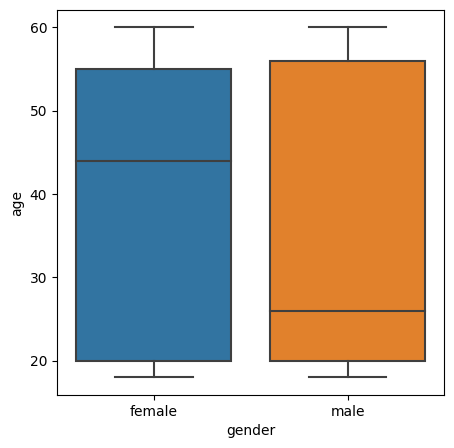

In [160]:
plt.figure(figsize=(5,5))
sns.boxplot(x='gender', y='age', data=df)
plt.show()

## show relation between X and Y